# WHAT DO YOU RECOMMEND? AN ANALYSIS OF SKINCARE PRODUCT REVIEWS

## Import and download necessary packages and libraries

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colormaps
from wordcloud import WordCloud
import nltk
import gensim
import sklearn
import seaborn as sns
from random import sample
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import datasets, metrics
import string
import sys
import spacy
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
!pip install contractions
import contractions
import re
from textblob import TextBlob
# from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.9 MB/s eta 0:00:00


In [117]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Read Product Reviews and Product Data

In [5]:
review_cols = ["rating", "review_text", "skin_tone", "product_id", "is_recommended"]


product_cols = ["product_id", "loves_count", "rating", "reviews", "price_usd", "value_price_usd", "limited_edition", "new", "primary_category"]

sephora_data = pd.read_csv("product_info.csv", usecols = product_cols)

reviews_0 = pd.read_csv("reviews_0-250.csv", usecols = review_cols, low_memory = False)
reviews_250 = pd.read_csv("reviews_250-500.csv", usecols = review_cols, low_memory = False)
reviews_500 = pd.read_csv("reviews_500-750.csv", usecols = review_cols, low_memory = False)
reviews_750 = pd.read_csv("reviews_750-1250.csv", usecols = review_cols, low_memory = False)
reviews_1250 = pd.read_csv("reviews_1250-end.csv", usecols = review_cols, low_memory = False)

data_cols = [reviews_0, reviews_250, reviews_500, reviews_750, reviews_1250]

reviews = pd.concat(data_cols)

In [7]:
# Dataframe shape
reviews.shape

(1094411, 5)

In [8]:
# Look at the data
reviews.head()

,rating,is_recommended,review_text,skin_tone,product_id
0,5,1.0,I use this with the Nudestix “Citrus Clean Bal...,NaN,P504322
1,1,0.0,I bought this lip mask after reading the revie...,NaN,P420652
2,5,1.0,My review title says it all! I get so excited ...,light,P420652
3,5,1.0,I’ve always loved this formula for a long time...,NaN,P420652
4,5,1.0,"If you have dry cracked lips, this is a must h...",light,P420652


In [9]:
# Isolate reveiws to just skincare products
sephora_data = sephora_data[sephora_data['primary_category'] == 'Skincare']

In [10]:
# Merge product and review data into one large dataset
all_data = reviews.merge(sephora_data, how = "left", on = "product_id")
print(all_data.shape)
all_data.head()

(1094411, 13)


,rating_x,is_recommended,review_text,skin_tone,product_id,loves_count,rating_y,reviews,price_usd,value_price_usd,limited_edition,new,primary_category
0,5,1.0,I use this with the Nudestix “Citrus Clean Bal...,NaN,P504322,177,5.0000,1.0,19.0,NaN,0,0,Skincare
1,1,0.0,I bought this lip mask after reading the revie...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
2,5,1.0,My review title says it all! I get so excited ...,light,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
3,5,1.0,I’ve always loved this formula for a long time...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
4,5,1.0,"If you have dry cracked lips, this is a must h...",light,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare


In [11]:
# Check merge worked by looking at the results for an example product
all_data[all_data["product_id"] == "P420652"]

,rating_x,is_recommended,review_text,skin_tone,product_id,loves_count,rating_y,reviews,price_usd,value_price_usd,limited_edition,new,primary_category
1,1,0.0,I bought this lip mask after reading the revie...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
2,5,1.0,My review title says it all! I get so excited ...,light,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
3,5,1.0,I’ve always loved this formula for a long time...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
4,5,1.0,"If you have dry cracked lips, this is a must h...",light,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
5,4,1.0,The scent isn’t my favourite but it works grea...,lightMedium,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16134,5,NaN,my lips were always dried during the seasons a...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
16135,5,NaN,I have the driest lips in the world and man oh...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
16136,5,NaN,"I swear by this for my dry, easily chapped lip...",NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare
16137,5,NaN,I have been using this mask for a while now. I...,NaN,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare


In [12]:
# Check merge worked by looking at the results for an example product
sephora_data[sephora_data["product_id"] == "P420652"]

,product_id,loves_count,rating,reviews,price_usd,value_price_usd,limited_edition,new,primary_category
4431,P420652,1081315,4.3508,16118.0,24.0,NaN,0,0,Skincare


## Check for and handle null values in the data

In [13]:
# Count null vals
print("product data:")
for col in sephora_data.columns:
  print(f"{col}: {sephora_data[col].isna().sum()}")

print("-------------------------")

print("reviews:")

for col in reviews.columns:
  print(f"{col}: {reviews[col].isna().sum()}")

print("-------------------------")

print("all:")

for col in all_data.columns:
  print(f"{col}: {all_data[col].isna().sum()}")

product data:
product_id: 0
loves_count: 0
rating: 69
reviews: 69
price_usd: 0
value_price_usd: 2258
limited_edition: 0
new: 0
primary_category: 0
-------------------------
reviews:
rating: 0
is_recommended: 167988
review_text: 1444
skin_tone: 170539
product_id: 0
-------------------------
all:
rating_x: 0
is_recommended: 167988
review_text: 1444
skin_tone: 170539
product_id: 0
loves_count: 0
rating_y: 0
reviews: 0
price_usd: 0
value_price_usd: 1063534
limited_edition: 0
new: 0
primary_category: 0


As we can see, there are null values in skin_tone, review_text, value_price_usd, ratings, and reviews. There is not simple way to impute skin_tone, but we can remove the data points that null entries. Skin tone is an important factor, especially for skincare products, which have historically been unaccessible to populations of people with darker skin. We can remove the data with no review text as 1444 is only a small fraction of the 1.1 million data points available. Nearly all the data points do not have a value_price_usd, which means they were not on sale. However, roughly 30,000 data points were on sale. We will turn this into a categorical feature that denotes if a product was on sale. We encode items on sale with 1 and items not on sale as 0. Finally, we can remove the data points with null ratings or reviews in the products data.

In [14]:
# Drop null values from the datasets
all_data = all_data.dropna(subset = ["review_text", "skin_tone", "is_recommended"])
reviews = reviews.dropna(subset = ["review_text", "skin_tone", "is_recommended"])
sephora_data = sephora_data.dropna(subset = ['rating', 'reviews'])

In [15]:
# Get the new sizes of the datasets
print(all_data.shape)
print(reviews.shape)
print(sephora_data.shape)

(884539, 13)
(884539, 5)
(2351, 9)


In [16]:
# Encode value price as categorcal variable to encode information
# that a product is on sale or not. Convert "is_recommended" to integer 1
# if recommended is true and otherwise 0
def fillValues(data):
    # Impute 0 for null value price and 1 for non null
  data.loc[:,'value_price_usd'] = data['value_price_usd'].fillna(0)
  data.loc[:, 'value_price_usd'] = [1 if x != 0 else 0 for x in data['value_price_usd']]
  data.loc[:, 'value_price_usd'] = data['value_price_usd'].astype("int64")

fillValues(sephora_data)
fillValues(all_data)

# Make recommended categorical
reviews.loc[:, 'is_recommended'] = reviews['is_recommended'].astype("int64")
all_data.loc[:, 'is_recommended'] = all_data['is_recommended'].astype("int64")




<ipython-input-16-cfc631bf7c2d>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'value_price_usd'] = [1 if x != 0 else 0 for x in data['value_price_usd']]
<ipython-input-16-cfc631bf7c2d>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  reviews.loc[:, 'is_recommended'] = reviews['is_recommended'].astype("int64")
<ipython-input-16-cfc631bf7c2d>:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either

In [17]:
# Check no null values remain
# Count null vals
print("product data:")
for col in sephora_data.columns:
  print(f"{col}: {sephora_data[col].isna().sum()}")

print("-------------------------")

print("reviews:")

for col in reviews.columns:
  print(f"{col}: {reviews[col].isna().sum()}")

print("-------------------------")

print("all:")

for col in all_data.columns:
  print(f"{col}: {all_data[col].isna().sum()}")

product data:
product_id: 0
loves_count: 0
rating: 0
reviews: 0
price_usd: 0
value_price_usd: 0
limited_edition: 0
new: 0
primary_category: 0
-------------------------
reviews:
rating: 0
is_recommended: 0
review_text: 0
skin_tone: 0
product_id: 0
-------------------------
all:
rating_x: 0
is_recommended: 0
review_text: 0
skin_tone: 0
product_id: 0
loves_count: 0
rating_y: 0
reviews: 0
price_usd: 0
value_price_usd: 0
limited_edition: 0
new: 0
primary_category: 0


# The data is clean, for now... Let's explore!

In [35]:
# Explore data not including the target variable of rating
cols = [x for x in sephora_data.columns if x != "rating"]

# Split data into features and target
x = sephora_data[cols]
y = sephora_data[["rating"]]


# Create Train-Test Splits of product data
x_train_prod, x_test_prod, y_train_prod, y_test_prod = train_test_split(x, y, test_size = .25, random_state = 100)

cols = [x for x in all_data.columns if x != "rating_x"]

x = all_data[cols]
y = all_data[['rating_x']]



# Create Train-Test Splits All Data
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x, y, test_size = .25, random_state = 100)

Explore The Product Data...

In [36]:
x_train_prod.head()

,product_id,loves_count,reviews,price_usd,value_price_usd,limited_edition,new,primary_category
6600,P458724,38239,237.0,18.0,0,0,0,Skincare
2185,P457522,15285,325.0,42.0,0,0,0,Skincare
7688,P427404,58355,166.0,19.8,0,0,0,Skincare
5203,P474075,7135,341.0,44.0,0,0,0,Skincare
1122,P503655,9290,8.0,12.0,0,0,0,Skincare


**Let's look at continuous variables first:**

In [37]:
# Feature descriptive statistics
price = x_train_prod['price_usd'].describe()
rating = y_train_prod['rating'].describe()
reviews = x_train_prod['reviews'].describe()
loves = x_train_prod['loves_count'].describe()

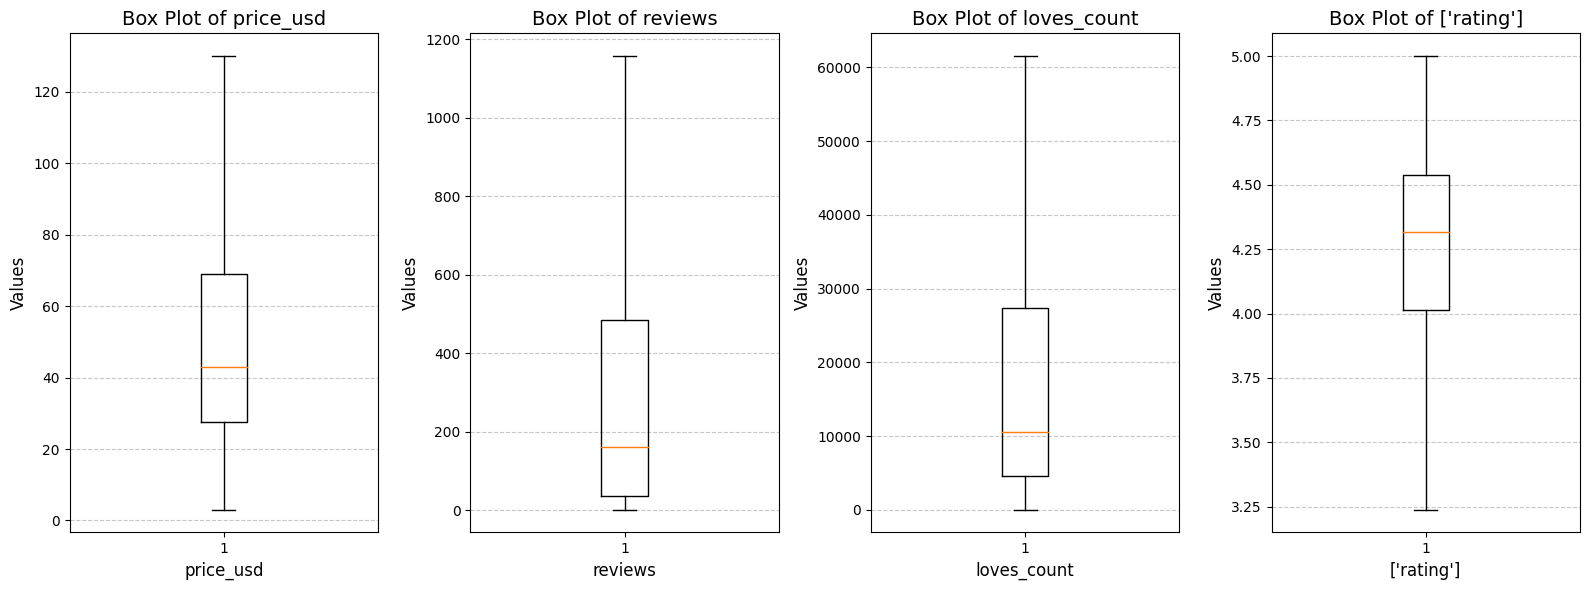

In [38]:
# Written with aid from generative AI
# Combine the values for different columns into a list
data_to_plot = [price, rating, reviews, loves]

# Define the columns to plot
columns_to_plot_x = ['price_usd', 'reviews', 'loves_count']
column_to_plot_y = ['rating']

# Create subplots for x_train_prod
fig, axes = plt.subplots(1, len(columns_to_plot_x) + 1, figsize=(16, 6))

# Plot each column in a separate subplot for x_train_prod
for i, column in enumerate(columns_to_plot_x):
    axes[i].boxplot(x_train_prod[column], showfliers=False)
    axes[i].set_title(f'Box Plot of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Values', fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='both', labelsize=10)

# Plot the 'rating' column in a separate subplot for y_train_prod
axes[-1].boxplot(y_train_prod[column_to_plot_y], showfliers=False)
axes[-1].set_title(f'Box Plot of {column_to_plot_y}', fontsize=14)
axes[-1].set_xlabel(column_to_plot_y, fontsize=12)
axes[-1].set_ylabel('Values', fontsize=12)
axes[-1].grid(axis='y', linestyle='--', alpha=0.7)
axes[-1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

**Let's look at categorial features next**

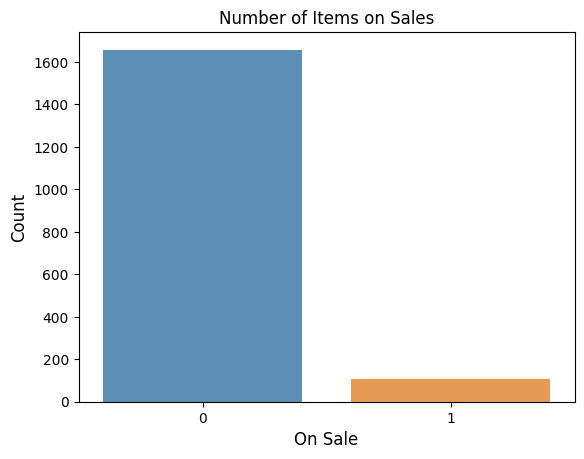

In [39]:
# https://www.kaggle.com/code/tejainece/seaborn-barplot-and-pandas-value-counts
vals = x_train_prod['value_price_usd'].value_counts()

sns.barplot(x = vals.index, y = vals.values, alpha=0.8)
plt.title('Number of Items on Sales')
plt.ylabel('Count', fontsize=12)
plt.xlabel('On Sale', fontsize=12)
plt.show()



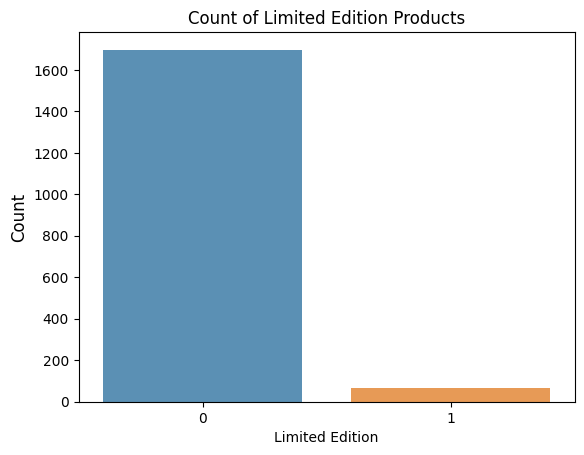

0    1697
1      66
Name: limited_edition, dtype: int64


In [40]:
vals = x_train_prod['limited_edition'].value_counts()

sns.barplot(x = vals.index, y = vals.values, alpha=0.8)
plt.title('Count of Limited Edition Products')
plt.ylabel('Count', fontsize=12)
plt.xlabel("Limited Edition")


plt.show()

print(x_train_prod['limited_edition'].value_counts())

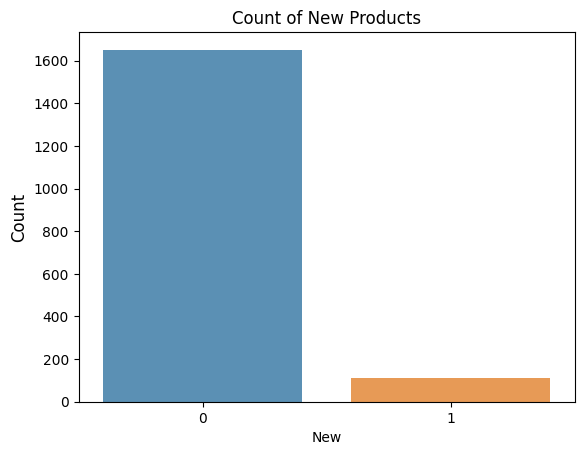

0    1651
1     112
Name: new, dtype: int64


In [41]:
vals = x_train_prod['new'].value_counts()

sns.barplot(x = vals.index, y = vals.values, alpha=0.8)
plt.title('Count of New Products')
plt.ylabel('Count', fontsize=12)
plt.xlabel("New")


plt.show()

print(x_train_prod['new'].value_counts())

Graphing Correlations:

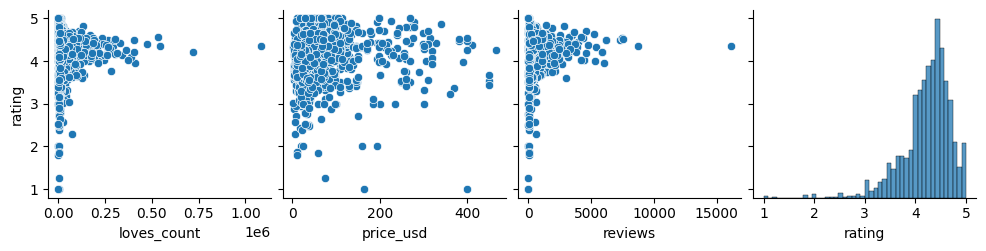

In [42]:
cols = ['loves_count', 'price_usd', 'reviews', 'rating']

train = x_train_prod.copy()
train['rating'] = y_train_prod.copy()

# Prune outliers to get better sense of data spread
pruned = train[train['price_usd'] < 500]

sns.pairplot(pruned, x_vars = cols, y_vars = ["rating"])

In [43]:
corr = train.corr()

<ipython-input-43-b40f162577fa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


<Axes: >

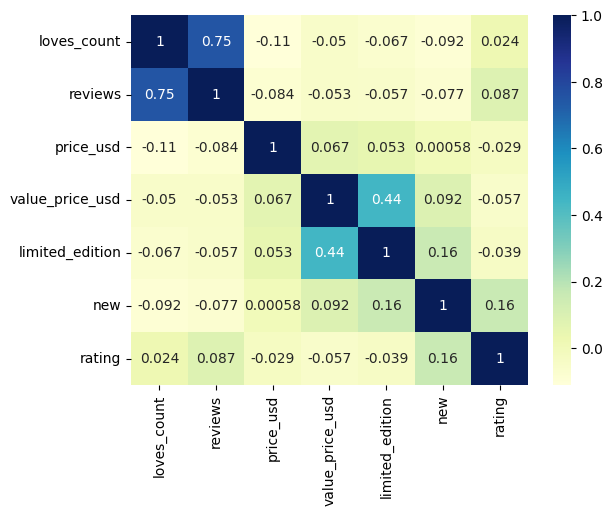

In [44]:
sns.heatmap(corr, cmap="YlGnBu", annot=True)

# Predictings Ratings from product features

In [46]:
# Extract feature columns (remove product id)
features = [x for x in x_train_prod if x != "product_id" and x !="primary_category"]

x_train_prod = x_train_prod[features]
x_train_prod = x_train_prod[features]

# save the names of the feature columns
columns = x_train_prod.columns

x_train_prod = x_train_prod[features].values
x_test_prod = x_test_prod[features].values

# Split the training data into train and validation sets
x_train = x_train_prod[0:1263]
x_val = x_train_prod[1263:]

y_train_prods = y_train_prod.values.reshape(-1,)
y_test = y_test_prod.values.reshape(-1,)

y_train = y_train_prods[0:1263]
y_val = y_train_prods[1263:]


# Scale data to mean 0 variance 1
scaler = StandardScaler().fit(x_train)
X_scaled = scaler.transform(x_train)
scaler = StandardScaler().fit(x_val)
X_val_scaled = scaler.transform(x_val)
scaler = StandardScaler().fit(x_test_prod)
X_test = scaler.transform(x_test_prod)

## Error Function

In [47]:
# Within 0.25
def getError(y , pred, plot = True):
  diff = abs(y - pred)
  length_near = len([x for x in diff if x <= 0.5])
  near = length_near/len(diff)
  print(f"Within 0.5: {near}")

  length_close = len([x for x in diff if x <= 0.25])
  close = length_close/len(diff)
  print(f"Within 0.25: {close}")

  length_very_close = len([x for x in diff if x <= 0.1])
  very_close = length_very_close/len(diff)
  print(f"Within 0.1: {very_close}")

  mse = mean_squared_error(y, pred)
  print("Mean Squared Error:", mse)

  # Get R2
  r2 = r2_score(y, pred)
  print("R2", r2)
  return

# Get error and print to output
def getStats(model):
  preds_train_lin = model.predict(X_scaled)
  print("Training Stats")
  getError(y_train, preds_train_lin)

  print("Validation Stats")
  preds_val_lin = model.predict(X_val_scaled)
  getError(y_val, preds_val_lin)

  print("Testing Stats")
  preds_val_lin = model.predict(X_test)
  getError(y_test, preds_val_lin)

# Get permutation importances of features
# Read more here:
# https://scikit-learn.org/stable/modules/permutation_importance.html
def permImp(imps):
  coefs = pd.DataFrame(
      imp.importances_mean, columns=["Importance Values"], index=columns
  )

  coefs.plot(kind="barh", figsize=(9, 7))
  plt.title("Feature Importances")
  plt.axvline(x=0, color=".5")
  plt.subplots_adjust(left=0.3)

  for name, weight in zip(columns, imp.importances_mean):
    print(f"{name}: {weight}")

In [52]:
# Run elastic net linear regression
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_scaled, y_train)

# Optimal regularizer
alph = regr.alpha_

# Run Elastic Net with optimal regularization
model = ElasticNet(alpha = alph, random_state=100)
model.fit(X_scaled, y_train)

# Evaluate model
getStats(model)

Training Stats
Within 0.5: 0.7616785431512272
Within 0.25: 0.46951702296120346
Within 0.1: 0.18210609659540775
Mean Squared Error: 0.2405851274618556
R2 0.02817469922421556
Validation Stats
Within 0.5: 0.828
Within 0.25: 0.484
Within 0.1: 0.18
Mean Squared Error: 0.17239120307138522
R2 0.05629062537751839
Testing Stats
Within 0.5: 0.7959183673469388
Within 0.25: 0.44727891156462585
Within 0.1: 0.20238095238095238
Mean Squared Error: 0.19792179570678053
R2 0.023419160703990416


Feature Importances

loves_count: -0.0
reviews: 0.027259105800064822
price_usd: -0.0
value_price_usd: -0.0009916479392386368
limited_edition: -0.02352278481366179
new: 0.05485379933174408


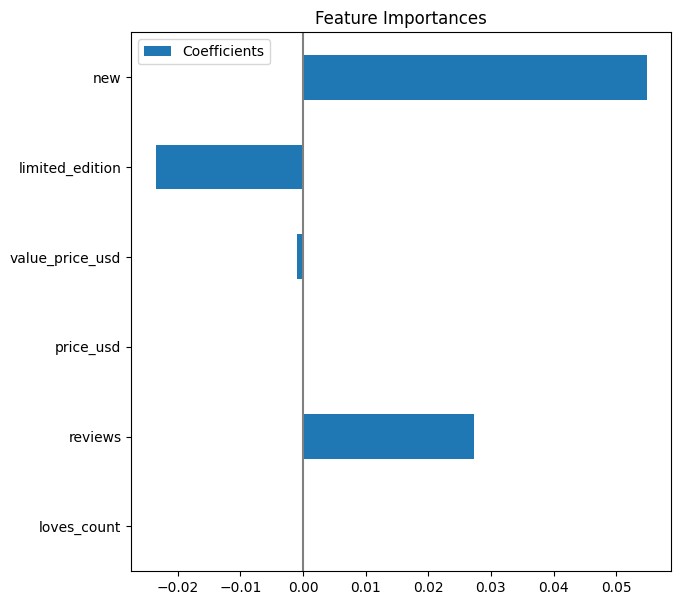

In [49]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index= columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Feature Importances")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

for name, weight in zip(columns, model.coef_):
  print(f"{name}: {weight}")


loves_count: 0.0
reviews: 0.007449931341995142
price_usd: 0.0
value_price_usd: 9.386152599213382e-05
limited_edition: 0.007607939009130904
new: 0.02860473152700742


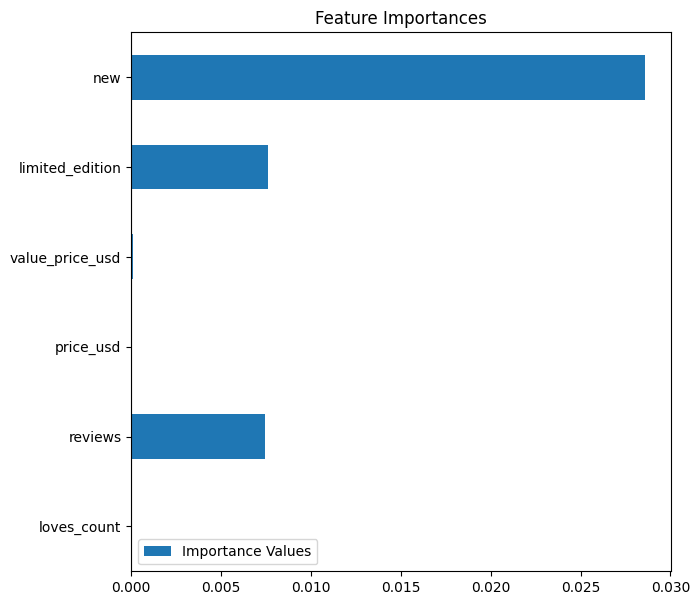

In [50]:
imp = permutation_importance(model, X_scaled, y_train)
permImp(imp)

# Random Forest Model

## Hyperparameter Tuning
Adapted from: https://medium.com/swlh/random-forest-from-model-building-to-hyperparameter-tuning-in-python-5d0c07a428eb and https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

In [51]:
param_grid = {
    "n_estimators":[100,300,500],
    "max_depth":[4, 8, 12],
    "max_features":[2, 4, 6]
}

rf_reg = RandomForestRegressor(random_state=100)

random_search = RandomizedSearchCV(rf_reg, param_grid, random_state=100)
random_search.fit(X_scaled, y_train)
print(random_search.best_estimator_)

RandomForestRegressor(max_depth=4, max_features=6, random_state=100)


### Run Random Forrest Regressor

In [53]:
# Take hyperparameters from grid search
model_rf = RandomForestRegressor(max_depth=4,
                                      max_features=6,
                                      n_estimators=300, random_state=100)
model_rf.fit(X_scaled, y_train)

getStats(model_rf)

Training Stats
Within 0.5: 0.8123515439429929
Within 0.25: 0.501187648456057
Within 0.1: 0.21773555027711797
Mean Squared Error: 0.18224228582578803
R2 0.2638461649513515
Validation Stats
Within 0.5: 0.79
Within 0.25: 0.506
Within 0.1: 0.228
Mean Squared Error: 0.22659353206184296
R2 -0.2404254777839967
Testing Stats
Within 0.5: 0.7687074829931972
Within 0.25: 0.4710884353741497
Within 0.1: 0.19047619047619047
Mean Squared Error: 0.26977145985474343
R2 -0.33109967875068924


Feature Importances

loves_count: 0.20286791920499206
reviews: 0.44353558628108325
price_usd: 0.2886818229608583
value_price_usd: 0.0035804945101633287
limited_edition: 0.009186025161964484
new: 0.052148151880938534


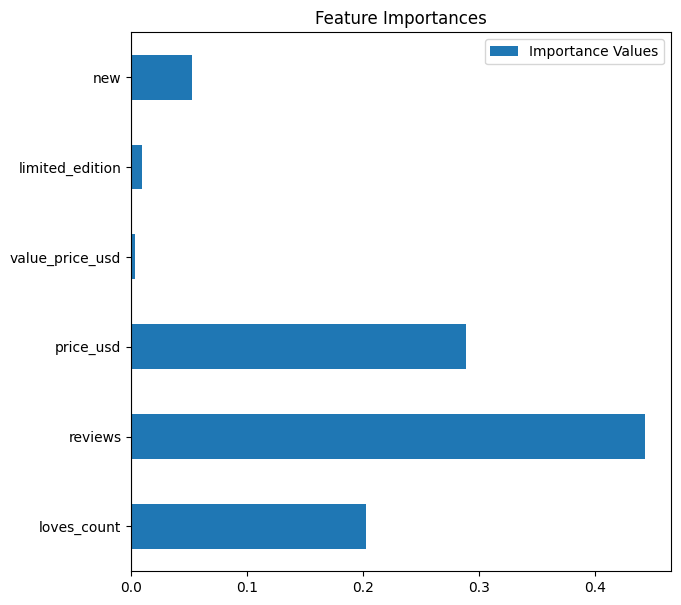

In [54]:
coefs = pd.DataFrame(
    model_rf.feature_importances_, columns=["Importance Values"], index=columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Feature Importances")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

for name, weight in zip(columns, model_rf.feature_importances_):
  print(f"{name}: {weight}")

loves_count: 0.07435737812269934
reviews: 0.26652526250577757
price_usd: 0.16483851078342618
value_price_usd: 0.001011591521650823
limited_edition: 0.0034001319638258033
new: 0.02363284708510891


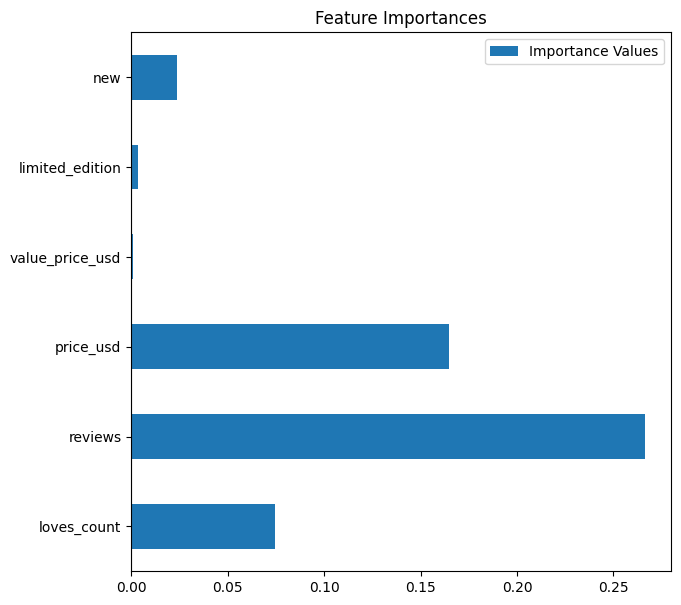

In [55]:
imp = permutation_importance(model_rf, X_scaled, y_train)
permImp(imp)

# K-Nearest Neighbors

In [56]:
# Find best value of K, look at point where error stops decreasing dramatically
# https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_scaled, y_train) #fit the model
    pred=model.predict(X_val_scaled) #make prediction on test set
    print(f"K: {K}")
    getError(y_val, pred, plot = False)

# At K = 6 the error stops decreasing dramatically. This is a hueristic
# hyperparameter tuning method
K = 6

K: 1
Within 0.5: 0.688
Within 0.25: 0.41
Within 0.1: 0.182
Mean Squared Error: 0.37922949712
R2 -1.0759901038414257
K: 2
Within 0.5: 0.736
Within 0.25: 0.466
Within 0.1: 0.232
Mean Squared Error: 0.297441684585
R2 -0.6282646744459093
K: 3
Within 0.5: 0.76
Within 0.25: 0.502
Within 0.1: 0.224
Mean Squared Error: 0.25278499700222223
R2 -0.3838036232981672
K: 4
Within 0.5: 0.778
Within 0.25: 0.506
Within 0.1: 0.226
Mean Squared Error: 0.22035798077
R2 -0.2062906257427657
K: 5
Within 0.5: 0.796
Within 0.25: 0.5
Within 0.1: 0.206
Mean Squared Error: 0.21252121965279996
R2 -0.1633903802475467
K: 6
Within 0.5: 0.804
Within 0.25: 0.522
Within 0.1: 0.212
Mean Squared Error: 0.20276859695888885
R2 -0.11000226473222785
K: 7
Within 0.5: 0.806
Within 0.25: 0.506
Within 0.1: 0.22
Mean Squared Error: 0.19658961461387753
R2 -0.07617708420837377
K: 8
Within 0.5: 0.812
Within 0.25: 0.522
Within 0.1: 0.228
Mean Squared Error: 0.19315893967750003
R2 -0.05739677499850537
K: 9
Within 0.5: 0.808
Within 0.25:

In [57]:
# Run and evaluate KNN model
model_knn = KNeighborsRegressor(n_neighbors = 6)

model_knn.fit(X_scaled, y_train)

getStats(model_knn)

Training Stats
Within 0.5: 0.8305621536025336
Within 0.25: 0.555027711797308
Within 0.1: 0.2367379255740301
Mean Squared Error: 0.17268723661938065
R2 0.30244305856197795
Validation Stats
Within 0.5: 0.804
Within 0.25: 0.522
Within 0.1: 0.212
Mean Squared Error: 0.20276859695888885
R2 -0.11000226473222785
Testing Stats
Within 0.5: 0.7261904761904762
Within 0.25: 0.45068027210884354
Within 0.1: 0.22448979591836735
Mean Squared Error: 0.24892052370039686
R2 -0.2282175042180452


In [58]:
# get feature importances
imp = permutation_importance(model_knn, X_scaled, y_train)

loves_count: 0.1983918263386783
reviews: 0.2228461437422163
price_usd: 0.3785901938041307
value_price_usd: 0.025809308129898477
limited_edition: 0.0621429050038008
new: 0.0803578355220755


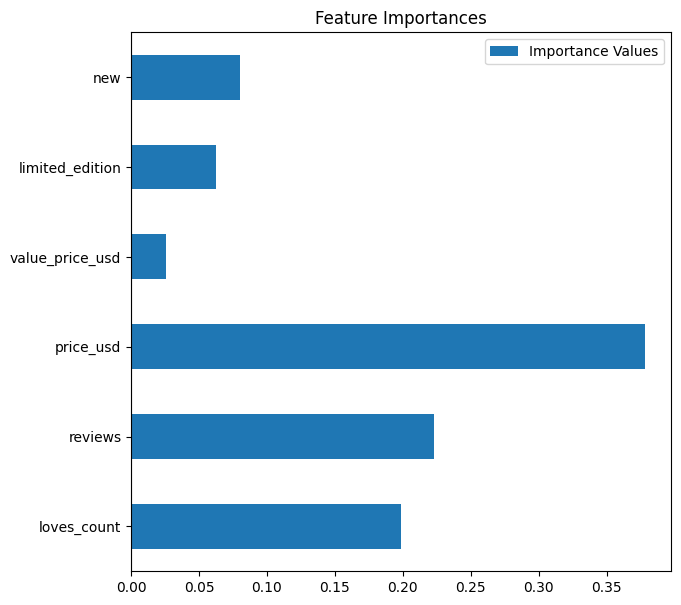

In [59]:
permImp(imp)

# Splitting and Sampling Data for Text Analysis

In [60]:
all_data['rating_x'].value_counts()

5    560075
4    162596
3     68551
1     49878
2     43439
Name: rating_x, dtype: int64

In [61]:
# samples 10,000 datapoints from each class of ratings
sample1 = all_data[all_data['rating_x']==1].sample(10000, random_state = 100)
sample2 = all_data[all_data['rating_x']==2].sample(10000, random_state = 100)
sample3 = all_data[all_data['rating_x']==3].sample(10000, random_state = 100)
sample4 = all_data[all_data['rating_x']==4].sample(10000, random_state = 100)
sample5 = all_data[all_data['rating_x']==5].sample(10000, random_state = 100)

data_cols = [sample1, sample2, sample3, sample4, sample5]

# Concatenate and shuffle results
all_data_sampled = sklearn.utils.shuffle(pd.concat(data_cols))
all_data_sampled.shape

(50000, 13)

In [62]:
# Look at inconsistent rating and recommendation
print(len(all_data_sampled[(all_data_sampled['rating_x'] == 4) & (all_data_sampled['is_recommended'] == 0)]))
len(all_data_sampled[(all_data_sampled['rating_x'] == 2) & (all_data_sampled['is_recommended'] == 1)])

376


371

In [63]:
# Look at spread of recommended to not recommended products
all_data_sampled['is_recommended'].value_counts()

0    26378
1    23622
Name: is_recommended, dtype: int64

In [64]:
# Split data into features and target
x = all_data_sampled[["review_text", "is_recommended", "product_id"]]
y = all_data_sampled[["rating_x"]]

# Create Train-Test Splits of Reviews
x_train_rev, x_test_rev, y_train_rev, y_test_rev = train_test_split(x, y, test_size = .25, random_state = 100)


# Exploring the text reviews and ratings

In [65]:
x_train_rev.head()

,review_text,is_recommended,product_id
892334,It’s not worth it at all! So expensive a coup...,0,P479632
802111,Bought this duo because I travel a lot for wor...,1,P405584
215987,I heard that this product was great to wear un...,0,P454380
227492,I received this product from Influenster in re...,0,P480612
715175,I’ve been using this for three weeks now. I li...,1,P479339


In [66]:
y_train_rev.head()

,rating_x
892334,2
802111,4
215987,2
227492,2
715175,3


In [67]:
# descriptive statistics of ratings
y_train_rev.describe()

,rating_x
count,37500.000000
mean,2.999200
std,1.413704
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [68]:
# count number of each type of review
y_train_rev['rating_x'].value_counts()

2    7552
5    7501
3    7493
1    7478
4    7476
Name: rating_x, dtype: int64

In [69]:
# count null values
y_train_rev['rating_x'].isna().sum()

0

In [70]:
# count number of each type of review
x_train_rev['review_text'].isna().sum()

0

In [71]:
# correlation betweeen recommendation and rating is very high
y_train_rev['rating_x'].corr(x_train_rev['is_recommended'])

0.8245191430991354

In [72]:
# check if reviews are redundant
counts = x_train_rev['review_text'].value_counts()
counts

I received this product complimentary from Influenster for testing purposes. All reviews are my own and unbiased. The product I received was a sample size containing approximately 7 days worth of product, so this must be taken into account. The texture of this serum is a nice texture. Not too thick or too runny. The scent is light and unbothersome. After a week of use,  I did notice my skin was more hydrated, but other than that, there was no difference. I did not notice any improvement in fine lines and wrinkles, nor did I notice improvement in radiance. I would not recommend this product. There are better products on the market for this purpose. I am a 39 yrs old Female with fine lines around my eyes and on forehead.                                                                                                                                                                                                        3
Overpriced, basic serum that will pill if used with the wrong products

## Create word cloud of reviews

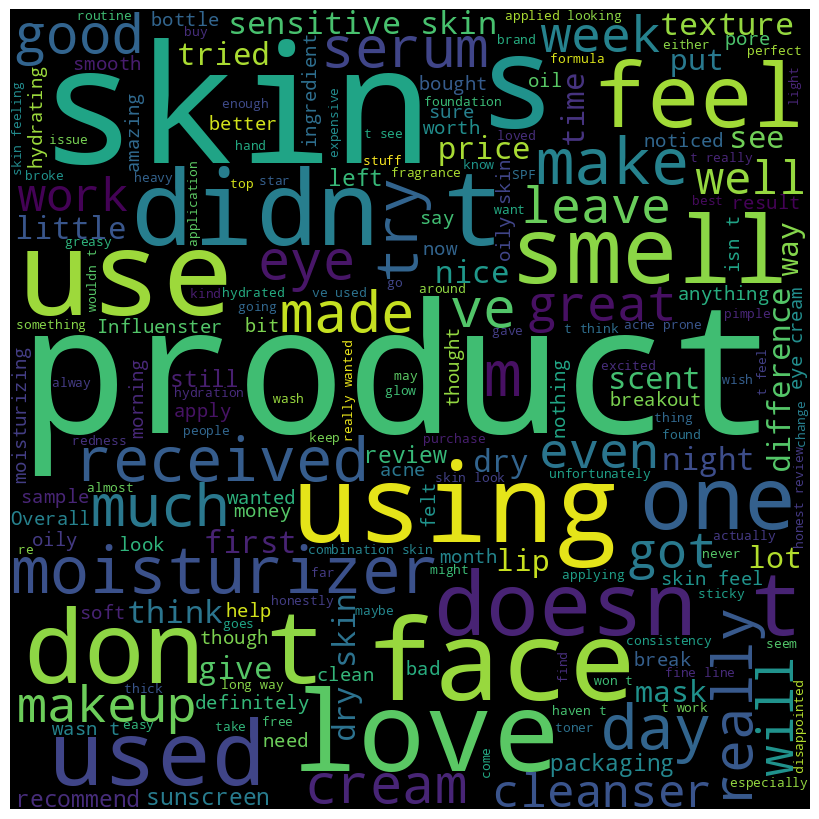

In [74]:
from google.colab import files
# https://medium.com/mlearning-ai/wordclouds-with-python-c287887acc8b
# word cloud
wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(x_train_rev['review_text'].values))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Pre-processing of text (Lemmatization, Lowercase, Remove Stop-Words, Tags)

Adapted from https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/ and https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

In [75]:
sample_text1 = x_train_rev.iloc[0, 0]
sample_text2 = x_train_rev.iloc[1, 0]
sample_text3 = x_train_rev.iloc[2, 0]
print(f"Sample 1: {sample_text1}")
print(f"Sample 2: {sample_text2}")
print(f"Sample 3: {sample_text3}")

Sample 1: It’s not worth it at all!  So expensive a couple of pumps and it’s over if you want to see results you need to use three of those!
Sample 2: Bought this duo because I travel a lot for work and the bars seemed more convenient than putting products into TSA containers. SO HAPPY I DID. The juju bar is now consistently in my line up, so much better (and gentle!) than other exfoliates. Will continue to repurchase, for sure!
Sample 3: I heard that this product was great to wear under makeup. Although I haven’t tried doing that yet, it probably is because it is extremely mattifying. Unfortunately, this is also what I don’t like about it. My skin feels uncomfortably dry after I put it on. It has a very weird texture, and after wearing it for a week straight I was quite disenchanted. On the plus side, like all Supergoop products, it is cruelty-free and reef-safe. I absolutely adore this brand and use a LOT of its products, but I won’t buy this one again.


In [76]:
# https://datagy.io/python-remove-punctuation-from-string/
# remove puncation
def removePunc(text):
    new_text = text.translate(str.maketrans('', '', string.punctuation + '“”'))
    return new_text

In [77]:
# Remove puncuation for all columns
def removeAllPuncuation(text):
    text.loc[:, 'review_text'] = text['review_text'].apply(lambda x:removePunc(x))

removeAllPuncuation(x_train_rev)
removeAllPuncuation(x_test_rev)

In [78]:
def toLower(text):
    text.loc[:, 'review_text'] = text['review_text'].apply(lambda x: x.lower())
toLower(x_train_rev)
toLower(x_test_rev)

In [79]:
# Remove Numbers
def noNums(text):
   text.loc[:, 'review_text']= text['review_text'].apply(lambda x: re.sub(r'\d+', '', x))
noNums(x_train_rev)
noNums(x_test_rev)

In [80]:
# Expand Contractions
# https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
def expandContractions(text):
    text.loc[:, 'review_text']= text['review_text'].apply(lambda x: contractions.fix(x))

expandContractions(x_train_rev)
expandContractions(x_test_rev)

In [81]:
# Remove Stopwords
stop_words = stopwords.words('english')
def removeStop(text):
    text.loc[:, 'review_text']= text['review_text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
removeStop(x_train_rev)
removeStop(x_test_rev)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
nlp = spacy.load('en_core_web_sm')
# Written using aid from generative AI
def lemmatize_column(df, column_name, model):
    lemmatized_column = []
    for doc in model.pipe(df[column_name], batch_size=100, disable=["parser", "ner"]):
        lemmatized_column.append(" ".join(token.lemma_ for token in doc))

    # Create a new DataFrame with the lemmatized column
    df_lemmatized = df.copy()
    df_lemmatized[column_name] = lemmatized_column

    return df_lemmatized

# Lemmatize the 'review_text' column
corpus_df = lemmatize_column(x_train_rev, 'review_text', nlp)
test_corpus_df = lemmatize_column(x_test_rev, 'review_text', nlp)

In [86]:
sample_text1 = x_train_rev.iloc[0, 0]
sample_text2 = x_train_rev.iloc[1, 0]
sample_text3 = x_train_rev.iloc[2, 0]
print(f"Sample 1: {sample_text1}")
print(f"Sample 2: {sample_text2}")
print(f"Sample 3: {sample_text3}")

Sample 1: worth expensive couple pumps want see results need use three
Sample 2: bought duo travel lot work bars seemed convenient putting products tsa containers happy juju bar consistently line much better gentle exfoliates continue repurchase sure
Sample 3: heard product great wear makeup although tried yet probably extremely mattifying unfortunately also like skin feels uncomfortably dry put weird texture wearing week straight quite disenchanted plus side like supergoop products crueltyfree reefsafe absolutely adore brand use lot products buy one


In [87]:
corpus_arr_train = np.array(corpus_df['review_text'])
corpus_arr_test = np.array(test_corpus_df['review_text'])

# TFIDF Vectorization

Adapted from https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

In [88]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# ignore terms that appear in 50% of the documents
cv_train = CountVectorizer(max_df=.5, min_df=.01, stop_words = ['use'])
count_vector_train = cv_train.fit_transform(corpus_arr_train)

# get tfidf values
tfidf_transformer_train=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer_train.fit(count_vector_train)

# create vector corresponding to tfidf values
tfidf_vector_train = tfidf_transformer_train.transform(count_vector_train)


# vectorize test data
count_vector_test = cv_train.transform(corpus_arr_test)
tfidf_vector_test = tfidf_transformer_train.transform(count_vector_test)


# turn values into vector
df_idf_train = pd.DataFrame(tfidf_transformer_train.idf_, index=cv_train.get_feature_names_out(), columns=["idf_weights"])

# print idf values in order highest to lowest
df_idf_train_sorted = df_idf_train.sort_values(by="idf_weights", ascending=True)

# Print the sorted DataFrame lowest to highest
print(df_idf_train_sorted.head(10))

# print idf values in order highest to lowest
df_idf_train_sorted = df_idf_train.sort_values(by="idf_weights", ascending=False)

# Print the sorted DataFrame highest to lowest
print(df_idf_train_sorted.head(10))


         idf_weights
product     1.743710
feel        2.100080
like        2.118760
love        2.395321
really      2.493758
would       2.499236
face        2.505105
get         2.548056
make        2.550064
dry         2.644194
          idf_weights
harsh        5.599878
scrub        5.599878
rather       5.594587
wipe         5.594587
save         5.591952
chemical     5.586702
neck         5.586702
similar      5.581480
excite       5.578880
blend        5.576286


In [89]:
corpus_df['tfidf'] = list(tfidf_vector_train.toarray())
test_corpus_df['tfidf'] = list(tfidf_vector_test.toarray())

# Modeling Ratings with TFIDF Vectors

In [90]:
ratings_train = y_train_rev['rating_x']
ratings_test = y_test_rev['rating_x']

In [95]:
# Isolate tfidf vector as training data
x_train_vecs = corpus_df[['review_text', 'tfidf']]
x_test_vecs = test_corpus_df[['review_text', 'tfidf']]

In [96]:
# Get target values
y_training = ratings_train.values
y_testing = ratings_test.values

In [97]:
# Debugged with generative AI, scale data
# Scale to mean 0 variance 1
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(tfidf_vector_train)
X_test_scaled = scaler.transform(tfidf_vector_test)

In [99]:
# define confusion function
def confusion_rating(y, y_pred):
  # confusin matrix
  cm = confusion_matrix(y, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['1', '2', '3', '4', '5'])
  disp.plot()

  print(classification_report(y, y_pred))

# take in training x and y data
def NB_train(x, y):
  #naive bayes classifier
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(x, y)

  #predicted y
  y_pred = naive_bayes_classifier.predict(x)

  confusion_rating(y, y_pred)


# take in training and testingx and y data
def NB_test(x_train, x_test, y_train, y_test):
  #naive bayes classifier
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(x_train, y_train)

  #predicted y
  y_pred = naive_bayes_classifier.predict(x_test)

  confusion_rating(y_test, y_pred)


# log regression train, increase max iterations to 1000 to converge
def log_train(x, y):

  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x, y)

  #predicted y
  y_pred = lr_classifier.predict(x)

  coefs = lr_classifier.coef_[0]

  # Aided by generative AI
  word_importances = dict(zip(cv_train.get_feature_names_out(), coefs))

  # Show word importances
  sorted_word_importances = sorted(word_importances.items(), key=lambda x: abs(x[1]), reverse=True)

  for word, importance in sorted_word_importances[:10]:
    print(f"{word}: {importance}")


  confusion_rating(y, y_pred)


#log regression test
def log_test(x_train, x_test, y_train, y_test):

  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x_train, y_train)


  #predicted y
  y_pred = lr_classifier.predict(x_test)

  confusion_rating(y_test, y_pred)

# Logistic Regression (predicting ratings)

love: -0.3976733329615212
great: -0.32244302939158825
return: 0.3041280347045834
amazing: -0.2667933889485481
soft: -0.2515530187449398
nice: -0.2390541596327154
unfortunately: 0.23787987040732236
want: 0.21545890133617637
easy: -0.2122887034592441
smooth: -0.20232622882007245
              precision    recall  f1-score   support

           1       0.59      0.66      0.62      7478
           2       0.43      0.37      0.40      7552
           3       0.47      0.44      0.45      7493
           4       0.50      0.47      0.48      7476
           5       0.62      0.69      0.65      7501

    accuracy                           0.53     37500
   macro avg       0.52      0.53      0.52     37500
weighted avg       0.52      0.53      0.52     37500



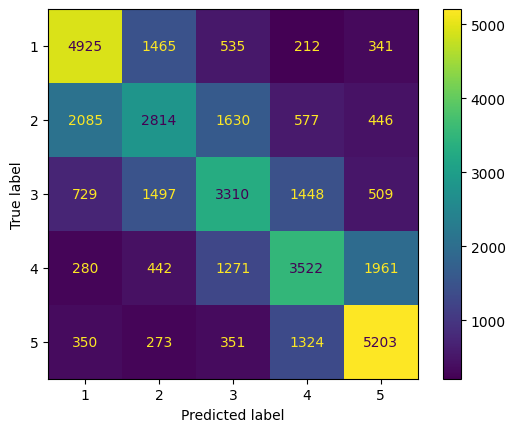

In [100]:
log_train(X_train_scaled, y_training)

              precision    recall  f1-score   support

           1       0.56      0.63      0.59      2522
           2       0.39      0.34      0.36      2448
           3       0.43      0.41      0.42      2507
           4       0.47      0.44      0.45      2524
           5       0.59      0.67      0.63      2499

    accuracy                           0.50     12500
   macro avg       0.49      0.50      0.49     12500
weighted avg       0.49      0.50      0.49     12500



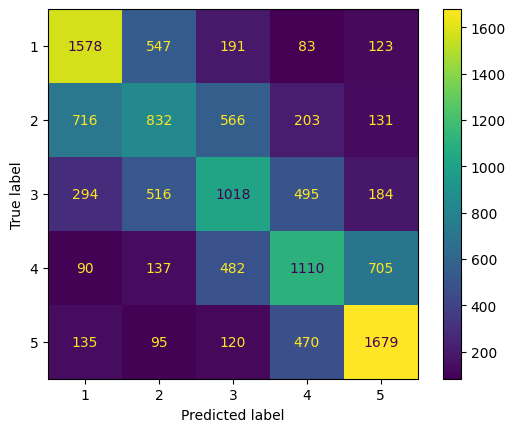

In [101]:
log_test(X_train_scaled, X_test_scaled, y_training, y_testing)

## Naive Bayes (predicting ratings)

              precision    recall  f1-score   support

           1       0.54      0.62      0.58      7478
           2       0.40      0.33      0.36      7552
           3       0.43      0.42      0.42      7493
           4       0.46      0.45      0.45      7476
           5       0.58      0.63      0.61      7501

    accuracy                           0.49     37500
   macro avg       0.48      0.49      0.48     37500
weighted avg       0.48      0.49      0.48     37500



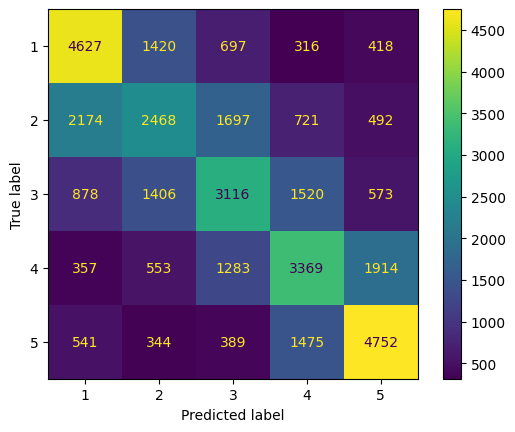

In [102]:
NB_train(X_train_scaled, y_training)

              precision    recall  f1-score   support

           1       0.53      0.61      0.56      2522
           2       0.37      0.31      0.34      2448
           3       0.41      0.39      0.40      2507
           4       0.45      0.44      0.44      2524
           5       0.57      0.63      0.60      2499

    accuracy                           0.47     12500
   macro avg       0.47      0.47      0.47     12500
weighted avg       0.47      0.47      0.47     12500



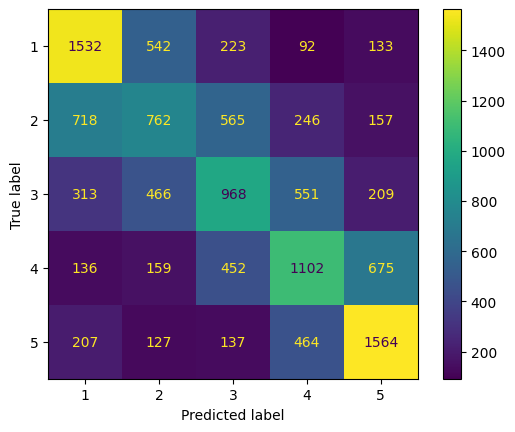

In [103]:
NB_test(X_train_scaled, X_test_scaled, y_training, y_testing)

## Random Forest (Predicting Ratings)

In [ ]:
# Hyperparameter Tuning
param_grid = {
    "n_estimators":[100, 150, 200],
    "max_depth":[8, 12, 15, 18],
    "max_features":[5, 10, 15]
}

rf_reg = RandomForestRegressor(random_state=100)

random_search = RandomizedSearchCV(rf_reg, param_grid, random_state=100)
random_search.fit(tfidf_vector_train, y_training)
print(random_search.best_estimator_)

In [104]:
# take in training x and y data and a vector represeting words in corpus
def randForestTrain(x, y, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x, y)

  #predicted y
  y_pred = rf.predict(x)

  confusion_rating(y, y_pred)

# take in training and testing x and y data
def randForestTest(x_train, x_test, y_train, y_test, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x_train, y_train)

  #predicted y
  y_pred = rf.predict(x_test)

  confusion_rating(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.52      0.81      0.64      7478
           2       0.66      0.43      0.52      7552
           3       0.67      0.52      0.58      7493
           4       0.65      0.53      0.59      7476
           5       0.62      0.75      0.68      7501

    accuracy                           0.61     37500
   macro avg       0.63      0.61      0.60     37500
weighted avg       0.63      0.61      0.60     37500



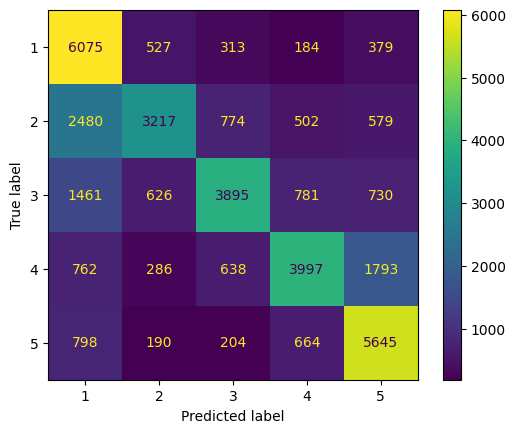

In [105]:
# Run rf
# Values from hyperparamter tuning
randForestTrain(X_train_scaled, y_training, depth = 12, max_feat=10, n_estim=200)

              precision    recall  f1-score   support

           1       0.45      0.72      0.56      2522
           2       0.37      0.20      0.26      2448
           3       0.43      0.33      0.37      2507
           4       0.46      0.41      0.43      2524
           5       0.52      0.63      0.57      2499

    accuracy                           0.46     12500
   macro avg       0.45      0.46      0.44     12500
weighted avg       0.45      0.46      0.44     12500



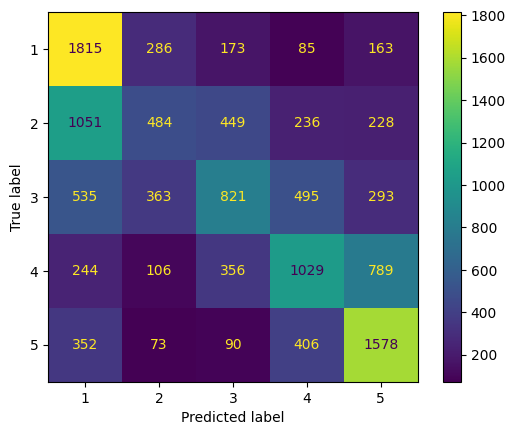

In [106]:
# Run rf
randForestTest(X_train_scaled, X_test_scaled, y_training, y_testing, depth = 12, max_feat=10, n_estim=200)

# Modeling Recommendations with TFIDF Vectors

In [108]:
# Get data for training and testing
y_training = x_train_rev['is_recommended']
y_testing = x_test_rev['is_recommended']

# Transform text to TF-IDF vectors
X_train_scaled = scaler.fit_transform(tfidf_vector_train)
X_test_scaled = scaler.transform(tfidf_vector_test)

X_test_scaled.shape


(12500, 436)

In [110]:
# define confusion matrix function
def confusion(y, y_pred):
  cm = confusion_matrix(y, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['0', '1'])
  disp.plot()

  print(classification_report(y, y_pred))

# take in training x and y data
def NB_train_rec(x, y):
  #naive bayes classifier
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(x, y)

  #predicted y
  y_pred = naive_bayes_classifier.predict(x)

  confusion(y, y_pred)


# take in training and testing x and y data
def NB_test_rec(x_train, x_test, y_train, y_test):
  #naive bayes classifier
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(x_train, y_train)

  #predicted y
  y_pred = naive_bayes_classifier.predict(x_test)

  confusion(y_test, y_pred)


# take in training x and y data
def log_train_rec(x, y):
  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x, y)

  coefs = lr_classifier.coef_[0]

  # Get and display word importances
  # Aided by generative AI
  word_importances = dict(zip(cv_train.get_feature_names_out(), coefs))


  sorted_word_importances = sorted(word_importances.items(), key=lambda x: abs(x[1]), reverse=True)

  for word, importance in sorted_word_importances[:10]:
    print(f"{word}: {importance}")


  #predicted y
  y_pred = lr_classifier.predict(x)

  confusion(y, y_pred)


  # take in training x and y data and a vector represeting words in corpus
def log_test_rec(x_train, x_test, y_train, y_test):
  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x_train, y_train)

  #predicted y
  y_pred = lr_classifier.predict(x_test)


  confusion(y_test, y_pred)



love: 0.5103361712149803
return: -0.43181900510150645
want: -0.38230393916557665
amazing: 0.3695353851833844
not: -0.34541793227710343
great: 0.32201246783862203
can: 0.3100108249255784
soft: 0.30903771899770377
smooth: 0.2880841385617852
nothing: -0.28232597937317294
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     19796
           1       0.81      0.79      0.80     17704

    accuracy                           0.81     37500
   macro avg       0.81      0.81      0.81     37500
weighted avg       0.81      0.81      0.81     37500



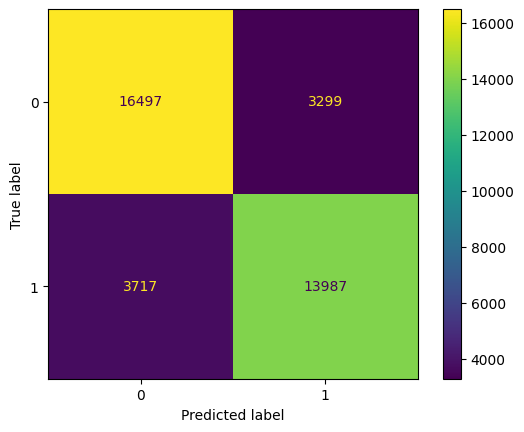

In [111]:
log_train_rec(X_train_scaled, y_training)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      6582
           1       0.80      0.78      0.79      5918

    accuracy                           0.80     12500
   macro avg       0.80      0.80      0.80     12500
weighted avg       0.80      0.80      0.80     12500



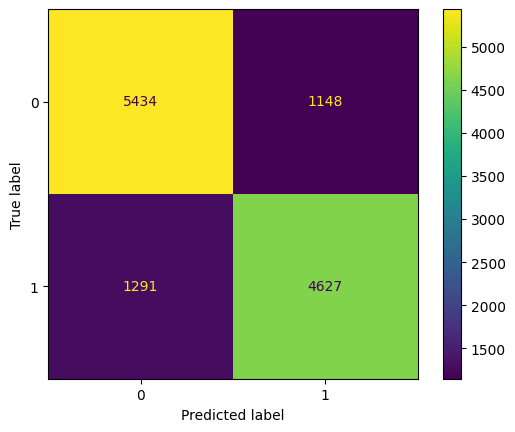

In [112]:
log_test_rec(X_train_scaled, X_test_scaled, y_training, y_testing)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     19796
           1       0.76      0.78      0.77     17704

    accuracy                           0.78     37500
   macro avg       0.78      0.78      0.78     37500
weighted avg       0.78      0.78      0.78     37500



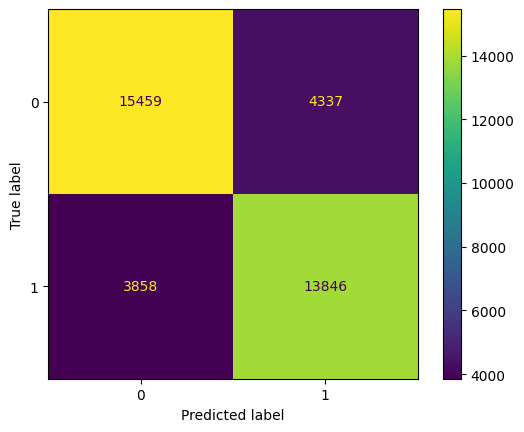

In [113]:
NB_train_rec(X_train_scaled, y_training)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      6582
           1       0.76      0.77      0.76      5918

    accuracy                           0.77     12500
   macro avg       0.77      0.77      0.77     12500
weighted avg       0.78      0.77      0.77     12500



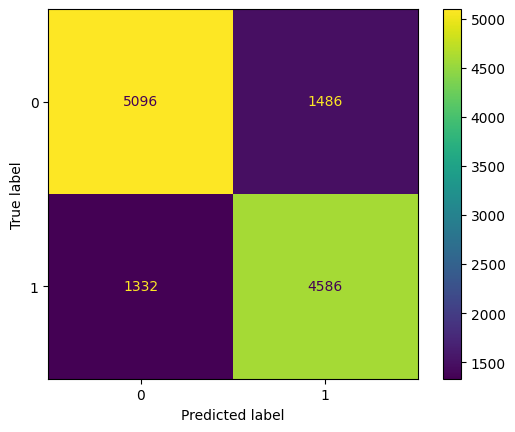

In [114]:
NB_test_rec(X_train_scaled, X_test_scaled, y_training, y_testing)

In [ ]:
# Hyperparameter Tuning
param_grid = {
    "n_estimators":[100, 150, 200],
    "max_depth":[8, 12, 15, 18],
    "max_features":[5, 10, 15]
}

rf_reg = RandomForestRegressor(random_state=100)

random_search = RandomizedSearchCV(rf_reg, param_grid, random_state=100)
random_search.fit(X_train_scaled, y_training)
print(random_search.best_estimator_)

RandomForestRegressor(max_depth=18, max_features=15, random_state=100)


In [115]:
# take in training x and y data and hyperamaters
def randForestTrain_rec(x, y, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x, y)

  #predicted y
  y_pred = rf.predict(x)

  confusion(y, y_pred)

  # take in training and testing x and y data
def randForestTest_rec(x_train, x_test, y_train, y_test, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x_train, y_train)

  #predicted y
  y_pred = rf.predict(x_test)

  confusion(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     19796
           1       0.90      0.78      0.83     17704

    accuracy                           0.85     37500
   macro avg       0.86      0.85      0.85     37500
weighted avg       0.86      0.85      0.85     37500



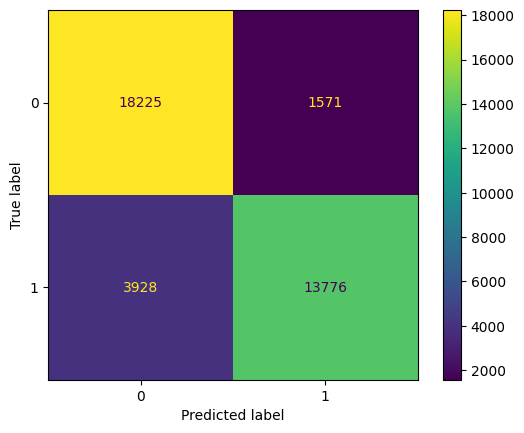

In [116]:
randForestTrain_rec(X_train_scaled, y_training, 18, 15, 100)

              precision    recall  f1-score   support

           0       0.75      0.85      0.79      6582
           1       0.80      0.68      0.73      5918

    accuracy                           0.77     12500
   macro avg       0.77      0.76      0.76     12500
weighted avg       0.77      0.77      0.77     12500



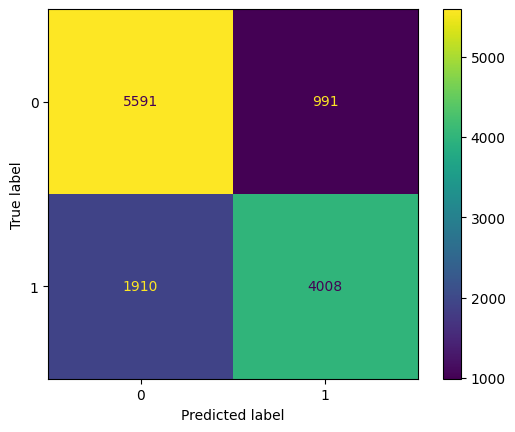

In [118]:
randForestTest_rec(X_train_scaled, X_test_scaled, y_training, y_testing, 18, 15, 100)

# Sentiment Analysis and Text Analysis

In [119]:
# Add length of text (before pre-processing) as feature
x_train_vecs['length'] = [len(x) for x in x_train_rev['review_text']]
x_test_vecs['length'] = [len(x) for x in x_test_rev['review_text']]

<ipython-input-119-3beb39f3da05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_vecs['length'] = [len(x) for x in x_train_rev['review_text']]
<ipython-input-119-3beb39f3da05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_vecs['length'] = [len(x) for x in x_test_rev['review_text']]


Sentiment Analyzer adapted from:
https://realpython.com/python-nltk-sentiment-analysis/

In [120]:
sia = SentimentIntensityAnalyzer()

# sentiment testing
x_train_vecs['pos'] = [sia.polarity_scores(col)['pos'] for col in x_train_vecs['review_text']]
x_train_vecs['neg'] = [sia.polarity_scores(col)['neg'] for col in x_train_vecs['review_text']]
x_train_vecs['neu'] = [sia.polarity_scores(col)['neu'] for col in x_train_vecs['review_text']]
x_train_vecs['com'] = [sia.polarity_scores(col)['compound'] for col in x_train_vecs['review_text']]

# sentiment testing
x_test_vecs['pos'] = [sia.polarity_scores(col)['pos'] for col in x_test_vecs['review_text']]
x_test_vecs['neg'] = [sia.polarity_scores(col)['neg'] for col in x_test_vecs['review_text']]
x_test_vecs['neu'] = [sia.polarity_scores(col)['neu'] for col in x_test_vecs['review_text']]
x_test_vecs['com'] = [sia.polarity_scores(col)['compound'] for col in x_test_vecs['review_text']]

In [121]:
# Combine text, ratings, recommended, for plots
x_train_vecs['rating'] = ratings_train
x_test_vecs['rating'] = ratings_test
x_train_vecs['is_recommended'] = corpus_df['is_recommended']
x_test_vecs['is_recommended'] = test_corpus_df['is_recommended']

In [122]:
correlation = x_train_vecs['length'].corr(x_train_vecs['rating'])
print(f"Correlation between review length and rating: {correlation}")
correlation = x_train_vecs['length'].corr(x_train_vecs['is_recommended'])
print(f"Correlation between review length and recommendation: {correlation}")
correlation = x_train_vecs['pos'].corr(ratings_train)
print(f"Correlation between pos and rating: {correlation}")
correlation = x_train_vecs['neg'].corr(ratings_train)
print(f"Correlation between neg and rating: {correlation}")
correlation = x_train_vecs['neu'].corr(ratings_train)
print(f"Correlation between neu and rating: {correlation}")
correlation = x_train_vecs['com'].corr(ratings_train)
print(f"Correlation between compound and rating: {correlation}")
correlation = x_train_vecs['pos'].corr(x_train_vecs['is_recommended'])
print(f"Correlation between pos and recommendation: {correlation}")
correlation = x_train_vecs['neg'].corr(x_train_vecs['is_recommended'])
print(f"Correlation between neg and recommendation: {correlation}")
correlation = x_train_vecs['neu'].corr(x_train_vecs['is_recommended'])
print(f"Correlation between neu and recommendation: {correlation}")
correlation = x_train_vecs['com'].corr(x_train_vecs['is_recommended'])
print(f"Correlation between compound and recommendation: {correlation}")

Correlation between review length and rating: 0.07016053265225686
Correlation between review length and recommendation: 0.07042973007703668
Correlation between pos and rating: 0.3682955645148052
Correlation between neg and rating: -0.3428372349878788
Correlation between neu and rating: -0.16519974595786535
Correlation between compound and rating: 0.4231960565758488
Correlation between pos and recommendation: 0.3234172170637596
Correlation between neg and recommendation: -0.2919309763086935
Correlation between neu and recommendation: -0.15097449315579475
Correlation between compound and recommendation: 0.36667646308172974


# Distributions of sentiment

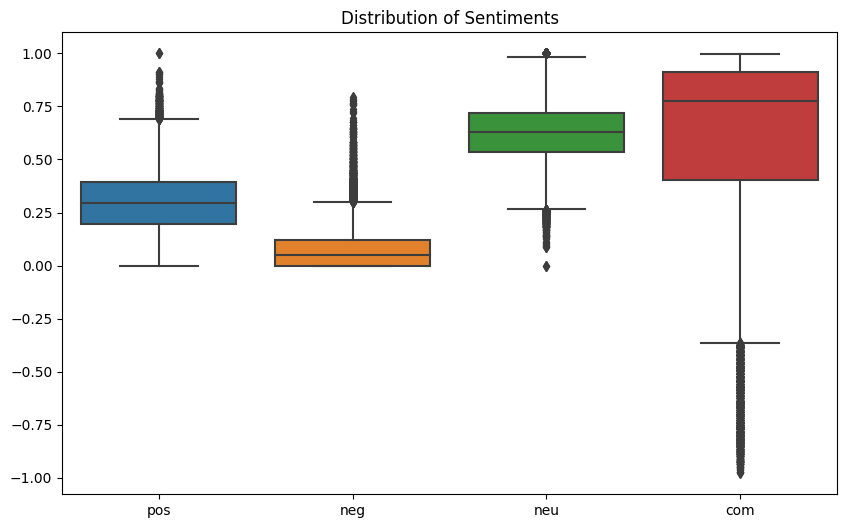

In [123]:
# Plots made with aid from generative AI
sentiments = ['pos', 'neg', 'neu', 'com']

# Create a DataFrame containing the sentiment data
data = pd.DataFrame({col: x_train_vecs[col] for col in sentiments})

# Plot box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('Distribution of Sentiments')
plt.show()

In [124]:
#Plotted with aid from generative AI

# Filter the DataFrame for different ratings
subset_df_5 = x_train_vecs[x_train_vecs['rating'] == 5]
subset_df_4 = x_train_vecs[x_train_vecs['rating'] == 4]
subset_df_3 = x_train_vecs[x_train_vecs['rating'] == 3]
subset_df_2 = x_train_vecs[x_train_vecs['rating'] == 2]
subset_df_1 = x_train_vecs[x_train_vecs['rating'] == 1]

# Filter the DataFrame for different ratings
subset_df_rec = x_train_vecs[x_train_vecs['is_recommended'] == 1]
subset_df_norec = x_train_vecs[x_train_vecs['is_recommended'] == 0]

In [125]:
# Aided by generative AI
def plots(name):
    # Combine the 'pos' values for different ratings into a list
    data_to_plot1 = [subset_df_rec[name], subset_df_norec[name]]
    data_to_plot2 = [subset_df_5[name], subset_df_4[name], subset_df_3[name], subset_df_2[name], subset_df_1[name], x_train_vecs[name]]

    # Create subplots with 1 row and 2 columns
    plt.figure(figsize=(8, 6))

    # Plot the first box plot
    plt.subplot(1, 2, 1)
    plt.boxplot(data_to_plot1, labels=['Recommended', 'Not Recommended'], showfliers=False)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('pos', fontsize=14)
    plt.title(f'Box Plot of {name} by Recommendations', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Plot the second box plot
    plt.subplot(1, 2, 2)
    plt.boxplot(data_to_plot2, labels=['5', '4', '3', '2', '1', 'All'], showfliers=False)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('', fontsize=14)
    plt.title(f'Box Plot of {name} for Different Ratings', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Adjust layout to prevent clipping of titles and labels
    plt.tight_layout()

    # Show the plots
    plt.show()

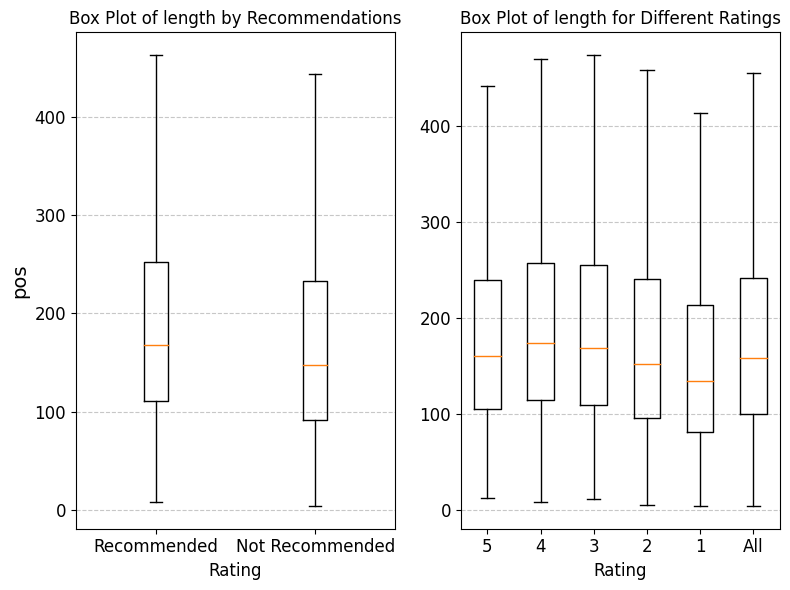

In [126]:
plots('length')

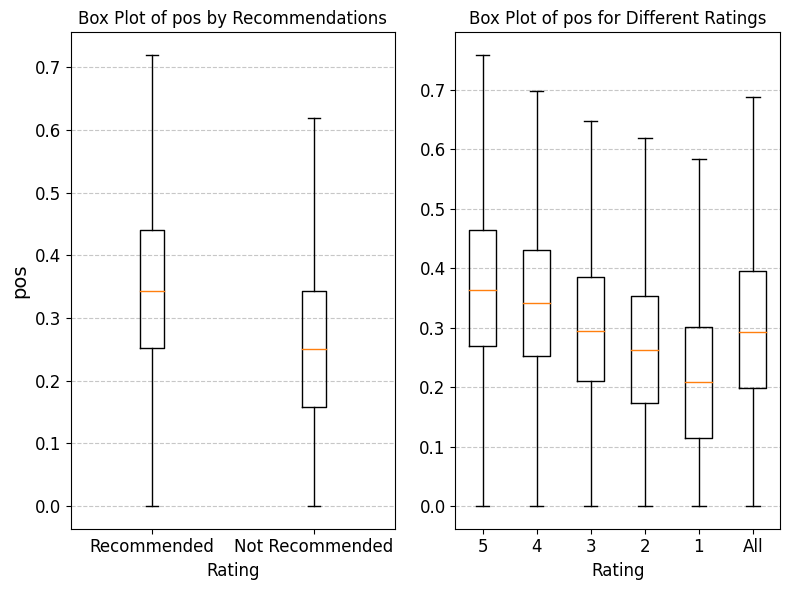

In [127]:
plots('pos')

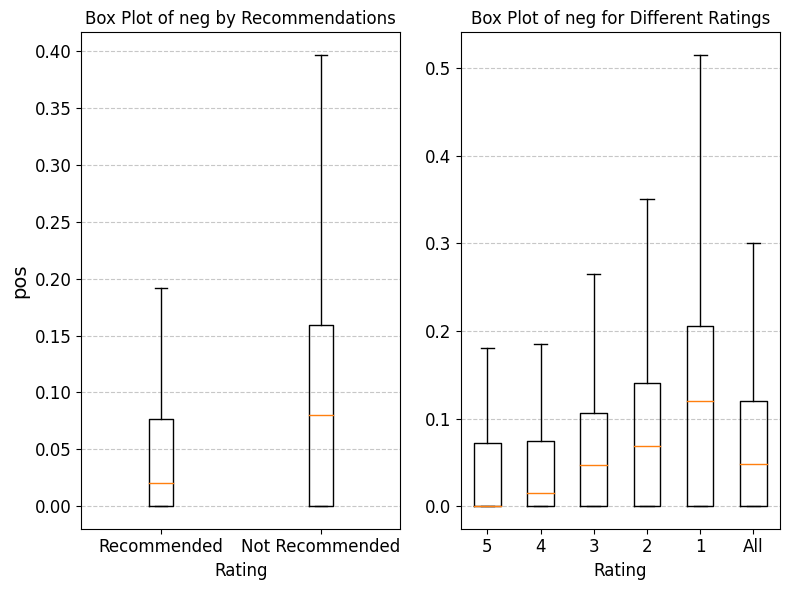

In [128]:
plots('neg')

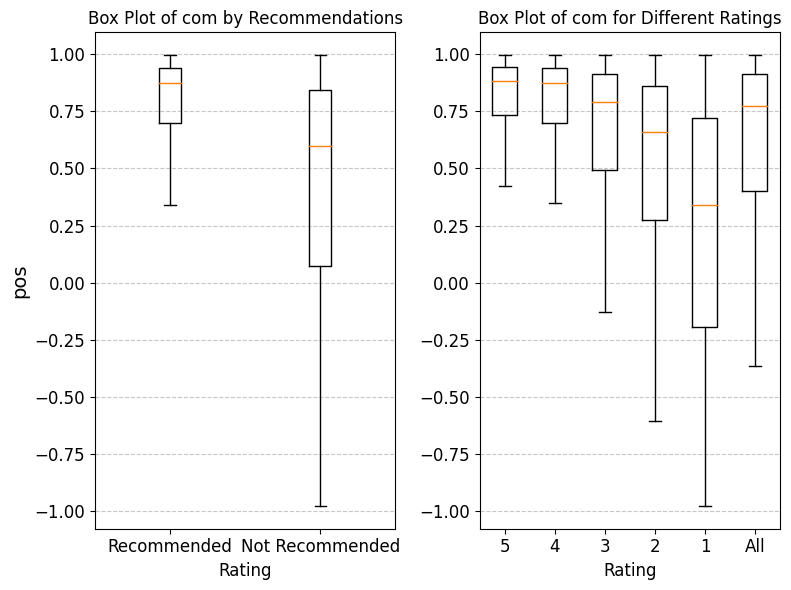

In [130]:
plots('com')

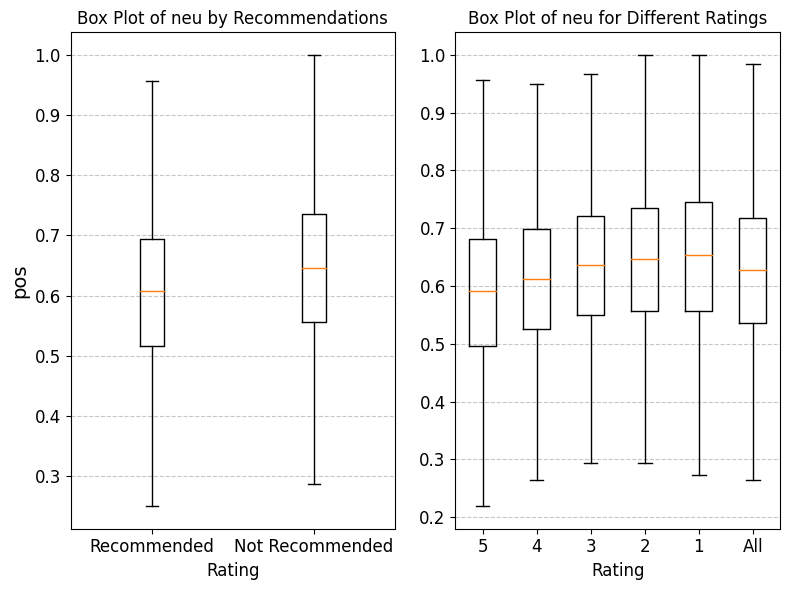

In [131]:
plots("neu")

# Training Models with Sentiment and Review Length


In [138]:
# Get pos, neg, neu, length
columns = ['pos', 'neu', 'neg', 'length']

sentiments_train_x = x_train_vecs[columns].values
sentiments_test_x = x_test_vecs[columns].values
sentiments_train_y_ratings = x_train_vecs['rating'].values
sentiments_test_y_ratings = x_test_vecs['rating'].values
sentiments_train_y_recs = x_train_vecs['is_recommended'].values
sentiments_test_y_recs = x_test_vecs['is_recommended'].values

# Scale data to mean 0 variance 1
scaler = StandardScaler().fit(sentiments_train_x)
sentiments_train_x = scaler.transform(sentiments_train_x)
scaler = StandardScaler().fit(sentiments_test_x)
sentiments_test_x = scaler.transform(sentiments_test_x)

In [155]:
# take in training x and y data
def log_train_rec(x, y):
  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x, y)

  #predicted y
  y_pred = lr_classifier.predict(x)

  confusion(y, y_pred)

# take in training and testing x and y data
def log_test_rec(x_train, x_test, y_train, y_test):
  lr_classifier = LogisticRegression(max_iter=1000)
  lr_classifier.fit(x_train, y_train)

  #predicted y
  y_pred = lr_classifier.predict(x_test)


  confusion(y_test, y_pred)

# take in training x and y data and hyperparamters
def randForestTrain_rec(x, y, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x, y)

  #predicted y
  y_pred = rf.predict(x)

  # Plot confusion matrix and feature importances
  confusion(y, y_pred)
  coefs = pd.DataFrame(
    rf.feature_importances_, columns=["Importance Values"], index=columns
)

  # coefs.plot(kind="barh", figsize=(6, 6))
  # plt.title("Feature Importances")
  # plt.axvline(x=0, color=".5")
  # plt.subplots_adjust(left=0.3)

  print("Feature Importances:")
  for name, weight in zip(columns, model_rf.feature_importances_):
    print(f"{name}: {weight}")

# take in training and testing x and y data and hyperparameters
def randForestTest_rec(x_train, x_test, y_train, y_test, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x_train, y_train)

  #predicted y
  y_pred = rf.predict(x_test)

  confusion(y_test, y_pred)

In [152]:
def permImp(imps):
  coefs = pd.DataFrame(
      imp.importances_mean, columns=["Importance Values"], index=columns
  )

  coefs.plot(kind="barh", figsize=(9, 7))
  plt.title("Feature Importances")
  plt.axvline(x=0, color=".5")
  plt.subplots_adjust(left=0.3)

  for name, weight in zip(x_train_vecs[columns], imp.importances_mean):
    print(f"{name}: {weight}")

# Run Logistic Regression

              precision    recall  f1-score   support

           0       0.69      0.66      0.67     19796
           1       0.64      0.66      0.65     17704

    accuracy                           0.66     37500
   macro avg       0.66      0.66      0.66     37500
weighted avg       0.66      0.66      0.66     37500



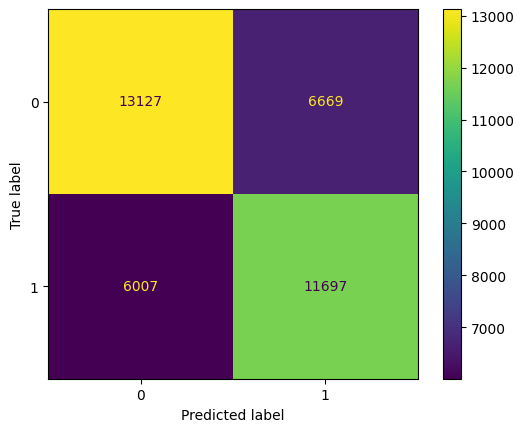

In [149]:
# Recs Train
log_train_rec(sentiments_train_x, sentiments_train_y_recs)

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      6582
           1       0.63      0.65      0.64      5918

    accuracy                           0.66     12500
   macro avg       0.66      0.66      0.66     12500
weighted avg       0.66      0.66      0.66     12500



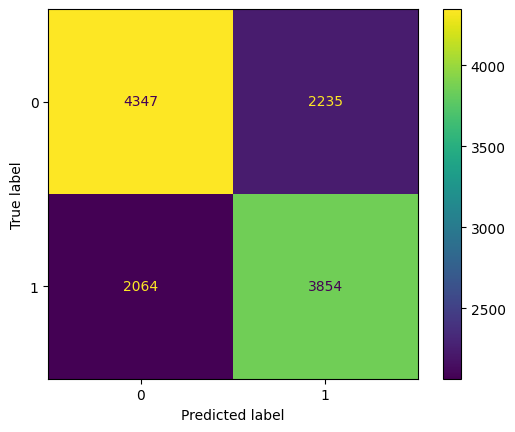

In [150]:
# Recs Test
log_test_rec(sentiments_train_x, sentiments_test_x, sentiments_train_y_recs, sentiments_test_y_recs)

# Run Logistic Regression

# Run Random Forest

In [ ]:
# hyperparamter tuning for recs
param_grid = {
    "max_depth":[2, 4, 6, 8, 10],
    "max_features":[2, 3, 4]
}

rf_reg = RandomForestRegressor(random_state=100)

random_search = RandomizedSearchCV(rf_reg, param_grid, random_state=100)
random_search.fit(sentiments_train_x, sentiments_train_y_recs)
print(random_search.best_estimator_)

RandomForestRegressor(max_depth=5, max_features=4, random_state=100)


              precision    recall  f1-score   support

           0       0.73      0.74      0.74     19796
           1       0.71      0.70      0.70     17704

    accuracy                           0.72     37500
   macro avg       0.72      0.72      0.72     37500
weighted avg       0.72      0.72      0.72     37500

Feature Importances:
pos: 0.20286791920499206
neu: 0.44353558628108325
neg: 0.2886818229608583
length: 0.0035804945101633287


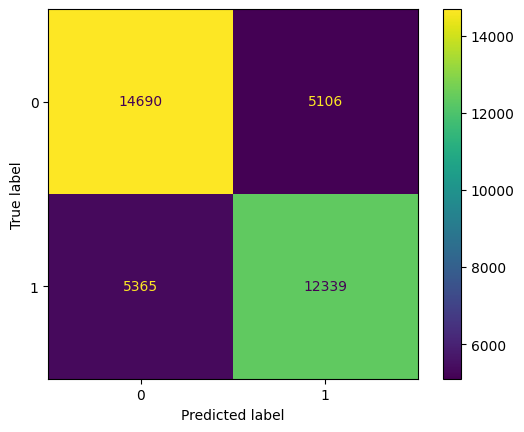

In [156]:
# Run model with hyperparamters from tuning grid
randForestTrain_rec(sentiments_train_x, sentiments_train_y_recs, 10, 4, 100)

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      6582
           1       0.65      0.64      0.64      5918

    accuracy                           0.66     12500
   macro avg       0.66      0.66      0.66     12500
weighted avg       0.66      0.66      0.66     12500



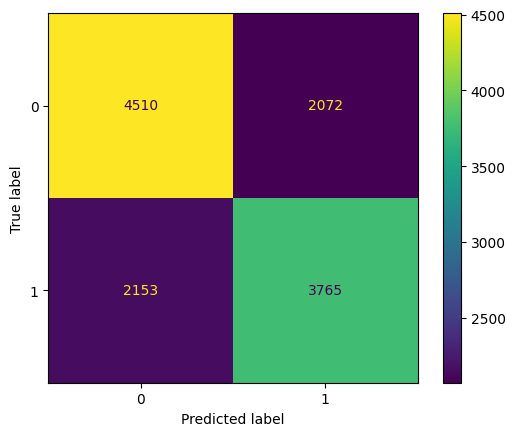

In [157]:
randForestTest_rec(sentiments_train_x, sentiments_test_x, sentiments_train_y_recs, sentiments_test_y_recs, 10, 4, 100)

# The following section is not used in my analysis as it provided poor results but it nonetheless reveals the difficulty of vectorizing text-based features.

#Doc2Vec

**Procedure follows gensim documentation: https://radimrehurek.com/gensim/models/doc2vec.html and uses default epochs features. Only considers words with at least 2 occurences. Also referenced: https://spotintelligence.com/2023/09/06/doc2vec/#:~:text=Doc2Vec%2C%20short%20for%20Document%2Dto,words%20in%20continuous%20vector%20space.**

In [158]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
nltk.download('punkt')

corpus_df['review_text_tokenized'] = corpus_df['review_text'].apply(lambda x: nltk.word_tokenize(x))
test_corpus_df['review_text_tokenized'] = test_corpus_df['review_text'].apply(lambda x: nltk.word_tokenize(x))

corpus_arr_train = np.array(corpus_df['review_text_tokenized'])
corpus_arr_test = np.array(test_corpus_df['review_text_tokenized'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
documents_train = [TaggedDocument(sent, [i]) for i, sent in enumerate(corpus_arr_train)]
documents_test = [TaggedDocument(sent, [i]) for i, sent in enumerate(corpus_arr_test)]
model = Doc2Vec(vector_size=100, min_count=2, workers=4)

In [ ]:
model.build_vocab(documents_train)

In [ ]:
# Train the model
model.train(documents_train, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
corpus_df['doc2vec'] = [model.dv[idx] for idx in range(len(documents_train))]
test_corpus_df['doc2vec'] = [model.dv[idx] for idx in range(len(documents_test))]

In [ ]:
corpus_df['doc2vec']
# Assuming df['doc2vec'] contains the vectors
doc2vec_matrix = np.vstack(corpus_df['doc2vec'].to_numpy())

# Check the shape of the resulting matrix
print(doc2vec_matrix.shape)

(37500, 100)


## With Doc2Vec

In [ ]:
x_train = corpus_df['doc2vec'].to_list()
x_test = test_corpus_df['doc2vec'].to_list()

y_training[0:20]

array([3, 1, 3, 2, 1, 3, 4, 4, 2, 4, 2, 5, 5, 2, 1, 5, 3, 2, 3, 5])

In [ ]:
# Debugged with generative AI, scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [ ]:
X_test_scaled.mean()

-0.00046338420241594615

## Logistic Regression

              precision    recall  f1-score   support

           1       0.48      0.54      0.51      7468
           2       0.35      0.28      0.31      7473
           3       0.38      0.37      0.37      7555
           4       0.42      0.40      0.41      7475
           5       0.54      0.61      0.57      7529

    accuracy                           0.44     37500
   macro avg       0.43      0.44      0.43     37500
weighted avg       0.43      0.44      0.43     37500



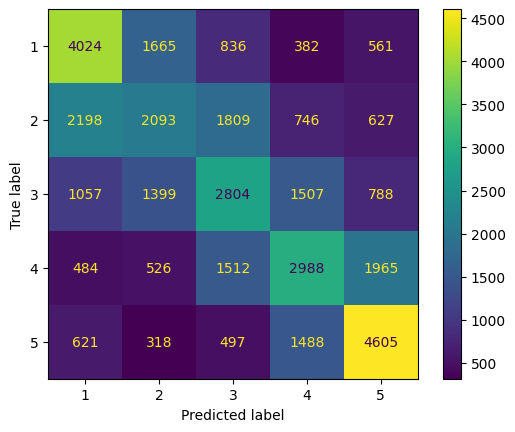

In [ ]:
# training
model = LogisticRegression()
model.fit(X_train_scaled, y_training)

preds = model.predict(X_train_scaled)
# confusin matrix
cm = confusion_matrix(y_training, preds)

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['1', '2', '3', '4', '5'])
disp.plot()

print(classification_report(y_training, preds))

In [ ]:
# Logistic regression test

              precision    recall  f1-score   support

           1       0.20      0.23      0.21      2532
           2       0.21      0.17      0.19      2527
           3       0.19      0.19      0.19      2445
           4       0.20      0.19      0.20      2525
           5       0.19      0.22      0.20      2471

    accuracy                           0.20     12500
   macro avg       0.20      0.20      0.20     12500
weighted avg       0.20      0.20      0.20     12500



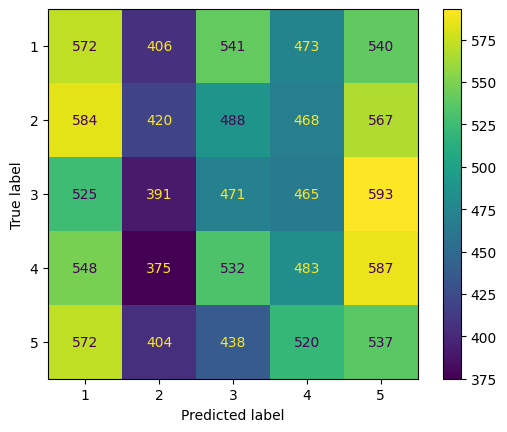

In [ ]:
preds = model.predict(X_test_scaled)
# confusin matrix
cm = confusion_matrix(y_testing, preds)

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['1', '2', '3', '4', '5'])
disp.plot()

print(classification_report(y_testing, preds))

# Random Forest

In [ ]:
# Hyperparameter Tuning
param_grid = {
    "n_estimators":[50, 100, 150],
    "max_depth":[8, 10, 12],
    "max_features":[8, 10, 12]
}

rf_reg = RandomForestRegressor(random_state=100)

random_search = RandomizedSearchCV(rf_reg, param_grid, random_state=100)
random_search.fit(X_train_scaled, y_training)
print(random_search.best_estimator_)

              precision    recall  f1-score   support

           1       0.41      0.69      0.52      7468
           2       0.40      0.11      0.17      7473
           3       0.40      0.37      0.38      7555
           4       0.43      0.28      0.34      7475
           5       0.46      0.67      0.55      7529

    accuracy                           0.43     37500
   macro avg       0.42      0.43      0.39     37500
weighted avg       0.42      0.43      0.39     37500



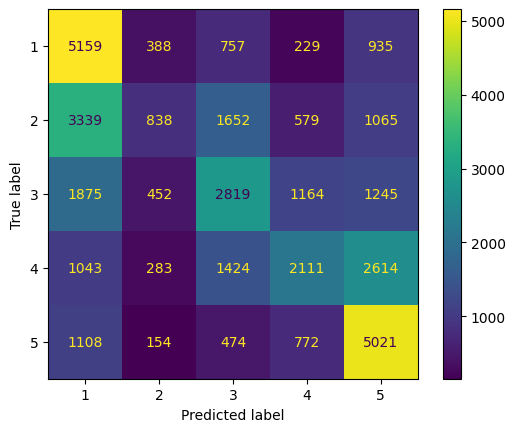

In [ ]:
randForestTrain(X_train_scaled, y_training, depth=5, max_feat=5, n_estim=100)

              precision    recall  f1-score   support

           1       0.19      0.35      0.25      2532
           2       0.27      0.00      0.00      2527
           3       0.20      0.29      0.23      2445
           4       0.22      0.09      0.12      2525
           5       0.20      0.27      0.23      2471

    accuracy                           0.20     12500
   macro avg       0.22      0.20      0.17     12500
weighted avg       0.22      0.20      0.17     12500



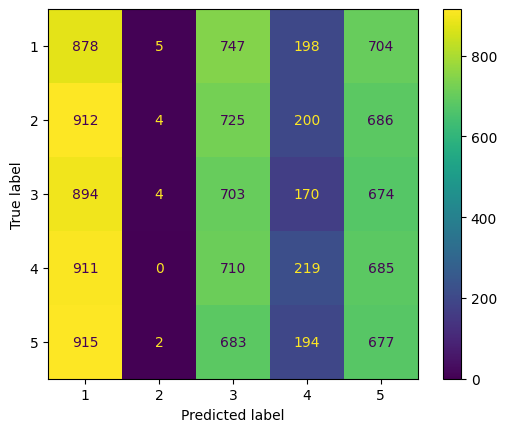

In [ ]:
def randForestTest(x_train, x_test, y_train, y_test, depth, max_feat, n_estim):
  #naive bayes classifier
  rf = RandomForestClassifier(max_depth=depth, max_features=max_feat, n_estimators=n_estim)
  rf.fit(x_train, y_train)

  #predicted y
  y_pred = rf.predict(x_test)

  # confusin matrix
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['1', '2', '3', '4', '5'])
  disp.plot()

  print(classification_report(y_test, y_pred))


randForestTest(X_train_scaled, X_test_scaled, y_training, y_testing, depth=1, max_feat=1, n_estim=10)